# Udacity SDND Project 5 -- Vehicle Detection Project
---

## Goals/Steps :
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    - Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
    - Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Preject details :

### Import libaraies

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Loading data

In [199]:
v_imgs = glob.glob('./dataset/vehicles/**/*.png')
nonv_imgs = glob.glob('./dataset/non-vehicles/**/*.png')

veh_imgs = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), v_imgs))
nonveh_imgs = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), nonv_imgs))

print('Number of vehicle\'s image: {}.'.format(len(veh_imgs)))
print('Number of non-vehicle\'s image: {}.'.format(len(nonveh_imgs)))

Number of vehicle's image: 8792.
Number of non-vehicle's image: 8968.


### Display some data

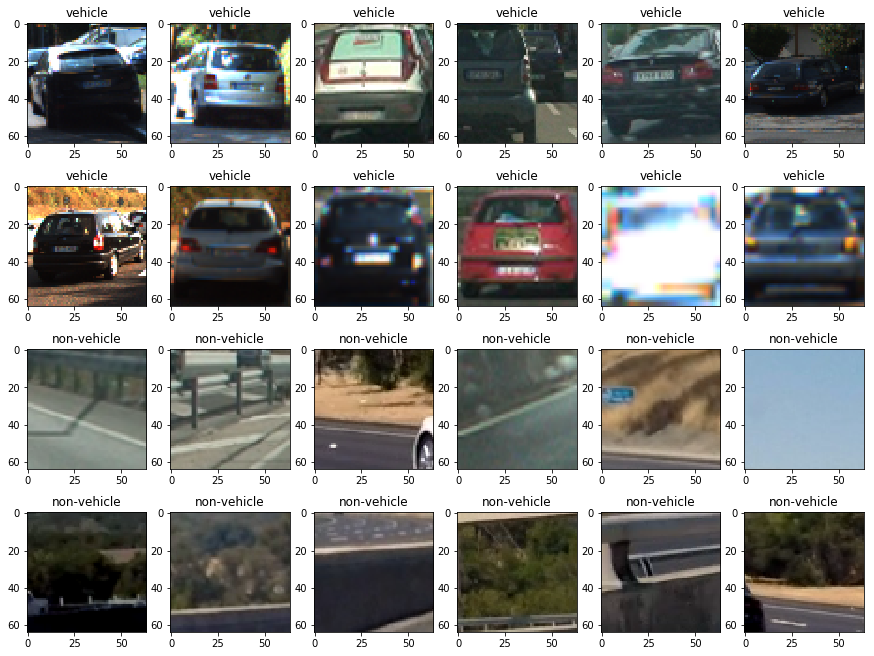

In [200]:
fig, axs = plt.subplots(4,6, figsize=(15, 15))
fig.subplots_adjust(hspace = -.5)
axs = axs.ravel()

for index in range(12):
    img = veh_imgs[np.random.randint(0,len(veh_imgs))]
    axs[index].set_title('vehicle')
    axs[index].imshow(img)
for index in range(12,24):
    img = nonveh_imgs[np.random.randint(0,len(nonveh_imgs))]
    axs[index].set_title('non-vehicle')
    axs[index].imshow(img)

### Features extraction (bin_spatial, color_hist, and HOG)
Features extraction functions learned from Udacity's course lectures.

In [201]:
# extract spatial features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
# extract color space histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# extract hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys', 
                                  transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),block_norm= 'L2-Hys', 
                       transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        return features
# extract all features (concatenate all applied features)
def extract_features(img, cspace='RGB', orient=9, hist_bins = 32, hist_range=(0, 256),
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    # spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    # hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return hog_features # np.concatenate((hist_features, hog_features))


Visualize a HOG features example

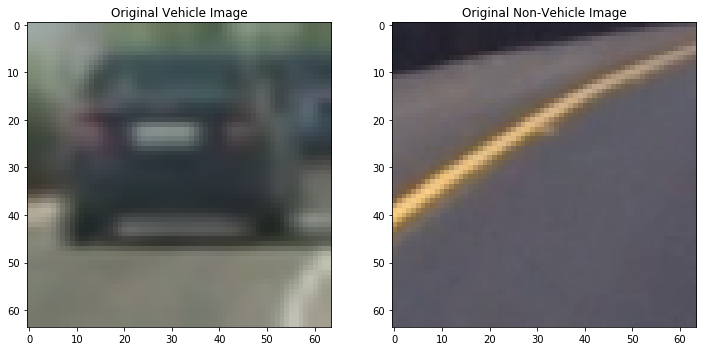

In [202]:
img_veh_hog_example = veh_imgs[1]
img_nonveh_hog_example = nonveh_imgs[10]

fig, axs = plt.subplots(1,2, figsize = (12,12))
axs[0].imshow(img_veh_hog_example)
axs[0].set_title('Original Vehicle Image')
axs[1].imshow(img_nonveh_hog_example)
axs[1].set_title('Original Non-Vehicle Image')

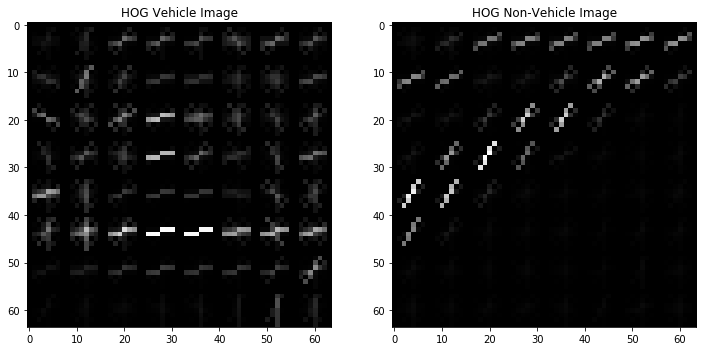

In [203]:
_, hog_veh_example = get_hog_features(img_veh_hog_example[:,:,0], 9, 8, 2, vis=True)
_, hog_nonveh_example = get_hog_features(img_nonveh_hog_example[:,:,0], 9, 8, 2, vis=True)

fig, axs = plt.subplots(1,2, figsize = (12,12))
axs[0].imshow(hog_veh_example, cmap='gray')
axs[0].set_title('HOG Vehicle Image')
axs[1].imshow(hog_nonveh_example, cmap='gray')
axs[1].set_title('HOG Non-Vehicle Image')

### Extract features for classifier input, define labels, shuffle and split
Most parts of the codes are modified and duplicated from Udacity's course lecture.

In [219]:
# Feature extraction para
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or 'ALL'
# hist_bins = 16

t = time.time()
veh_features = list(map(lambda img: extract_features(img, cspace=color_space, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel), veh_imgs))
nonveh_features = list(map(lambda img: extract_features(img, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel), nonveh_imgs))
t2 = time.time()
print(round(t2-t, 2), 'seconds to extract HOG features.')
# Create an array stack of feature vectors
X = np.vstack((veh_features, nonveh_features)).astype(np.float64)  
# Define the labels vector
y = np.hstack((np.ones(len(veh_features)), np.zeros(len(nonveh_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
# X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
#scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)


46.41 seconds to extract HOG features.


### Train SVM classifier

In [220]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
# Check the score of the SVC
print('Test Accuracy of SVC: ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('Actual labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict', n_predict,'labels with SVC.')

8.47 seconds to train SVC.
Test Accuracy of SVC:  0.9758
SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
Actual labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
0.004 seconds to predict 10 labels with SVC.


### Detect vehicles in an image
Most of codes are revised from Udacity's course lectrue.

In [221]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_vehs(img, ystart, ystop, scale, cspace, svc, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins = 16):
    
    # array of rectangles where cars were detected
    rectangles = []
    img_tosearch = img[ystart:ystop,:,:]

    # convert color if not 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  
    nyblocks = (ch1.shape[0] // pix_per_cell)+1   
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            

            # Extract the image patch
            # subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))       
            # test_prediction = svc.predict(test_features)
            
            hog_features = hog_features.reshape(1,-1)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [222]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

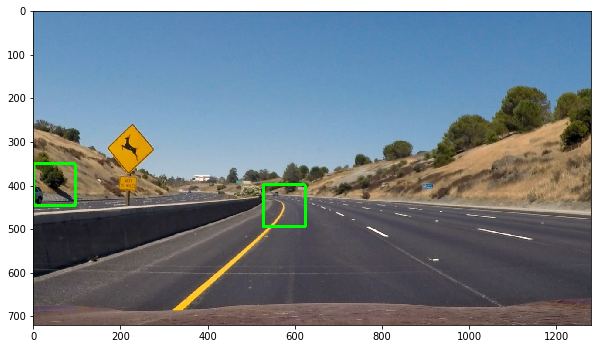

In [223]:
test_img = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'),cv2.COLOR_BGR2RGB)

ystart = 350
ystop = 600
scale = 1.5

rectangles = find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None)

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

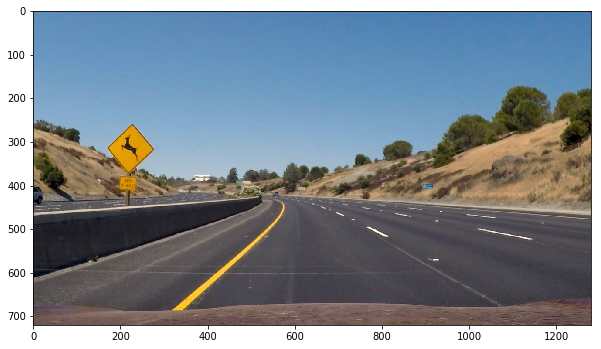

In [224]:
ystart = 350
ystop = 450
scale = 1.2

rectangles = find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None)

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

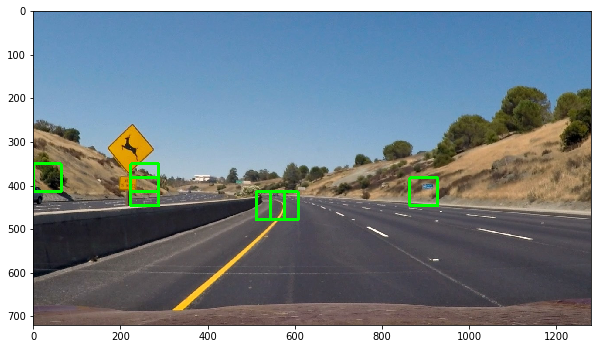

In [225]:
ystart = 350
ystop = 500
scale = 1

rectangles = find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None)

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

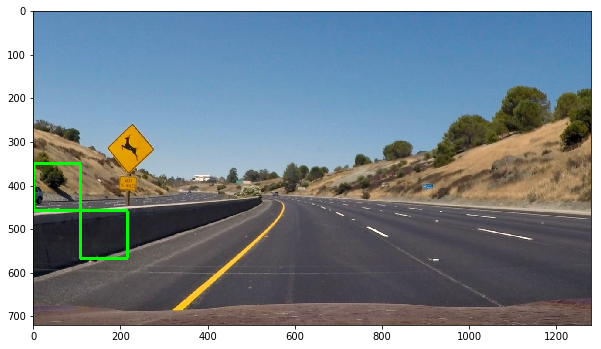

In [226]:
ystart = 350
ystop = 600
scale = 1.7

rectangles = find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None)

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

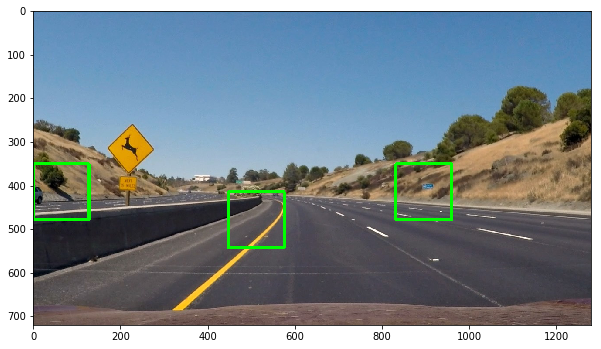

In [227]:
ystart = 350
ystop = 650
scale = 2

rectangles = find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None)

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Combine various size sliding window searches

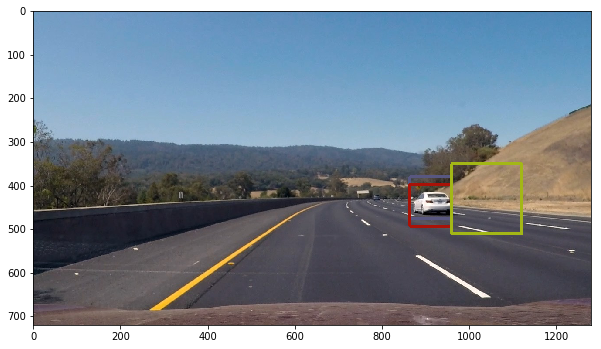

In [228]:
test_img = cv2.cvtColor(cv2.imread('./test_images/test3.jpg'),cv2.COLOR_BGR2RGB)
rectangles = []

ystart = 370
ystop = 420
scale = 1
rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

ystart = 390
ystop = 440
scale = 1.0
rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

ystart = 370
ystop = 450
scale = 1.5

rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

ystart = 380
ystop = 480
scale = 1.5

rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

ystart = 397
ystop = 500
scale = 1.5

rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

ystart = 400
ystop = 550
scale = 2

rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

ystart = 350
ystop = 600
scale = 2.5

rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

ystart = 380
ystop = 630
scale = 3

rectangles.append(find_vehs(test_img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))


rectangles = [rec for sublist in rectangles for rec in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=5)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Heatmap to filter false positive
Most of codes are from Udacity's course lectures.

In [229]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

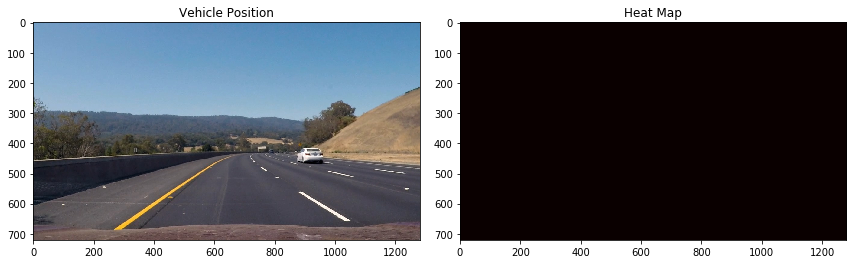

In [230]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

heatmap = add_heat(heat, rectangles)
heatmap = apply_threshold(heatmap, 3)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

fig, axs = plt.subplots(1,2, figsize = (12,12))
axs[0].imshow(draw_img)
axs[0].set_title('Vehicle Position')
axs[1].imshow(heatmap, cmap='hot')
axs[1].set_title('Heat Map')
fig.tight_layout()

### Image pipeline

In [231]:
def img_pipeline(img):
    rec = []
    # parameters
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    
    
    ystart = 370
    ystop = 420
    scale = 1
    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 390
    ystop = 440
    scale = 1.0
    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 370
    ystop = 450
    scale = 1.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 380
    ystop = 480
    scale = 1.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 397
    ystop = 500
    scale = 1.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 550
    scale = 2

    rec.append(find_vehs(img, ystart, ystop,
                         scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 350
    ystop = 600
    scale = 2.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 380
    ystop = 630
    scale = 3

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))



    
    rect = [item for sublist in rec for item in sublist] 
    # draw heatmap
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rect)
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    drawn_img = draw_labeled_bboxes(np.copy(img), labels)
    return drawn_img

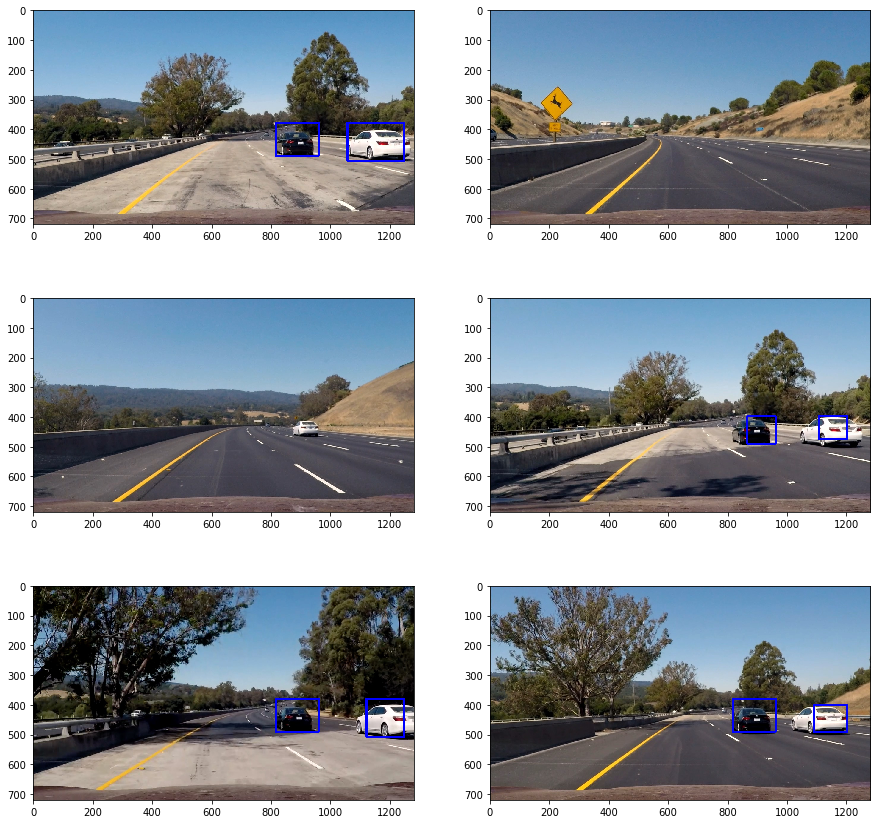

In [232]:
test_imgs = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(15,15))
axs = axs.ravel()

for i, im in enumerate(test_imgs):
    axs[i].imshow(img_pipeline(cv2.cvtColor(cv2.imread(im),cv2.COLOR_BGR2RGB)))
    

### Define a class to store data from previous frame

In [233]:
class veh_detected():
    def __init__(self):
        self.pre_rects = []
        
    def add_rects(self, rects):
        self.pre_rects.append(rects)
        if len(self.pre_rects) > 10:
            # keep the rects in the latest 10 frames
            kp_index = len(self.pre_rects) - 10
            self.pre_rects = self.pre_rects[kp_index:]

### Video pipeline

In [234]:
def video_pipeline(img):
    rec = []
    # parameters
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    
        
    ystart = 370
    ystop = 420
    scale = 1
    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 390
    ystop = 440
    scale = 1.0
    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 370
    ystop = 450
    scale = 1.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 380
    ystop = 480
    scale = 1.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 397
    ystop = 500
    scale = 1.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 550
    scale = 2

    rec.append(find_vehs(img, ystart, ystop,
                         scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 350
    ystop = 600
    scale = 2.5

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 380
    ystop = 630
    scale = 3

    rec.append(find_vehs(img, ystart, ystop, 
                                scale, color_space, svc, orient, pix_per_cell, cell_per_block, None, None))


    
    rect = [item for sublist in rec for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        detected.add_rects(rectangles)
    
    # draw heatmap
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rect)
    heatmap_img = apply_threshold(heatmap_img, 3)
    labels = label(heatmap_img)
    drawn_img = draw_labeled_bboxes(np.copy(img), labels)
    return drawn_img

In [235]:
detected = veh_detected()

from moviepy.editor import VideoFileClip
clip_test = VideoFileClip('test_video.mp4')
test_out = 'test_video_out.mp4'
clip_test_out = clip_test.fl_image(video_pipeline)
%time clip_test_out.write_videofile(test_out, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 10.2 s


In [198]:
detected = veh_detected()

clip_proj = VideoFileClip('project_video.mp4')
proj_out = 'project_video_out.mp4'
clip_proj_out = clip_proj.fl_image(video_pipeline)
%time clip_proj_out.write_videofile(proj_out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:06<00:00,  3.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 5min 7s
